# Reading shapefile data in Python

In [7]:
import shapefile
import matplotlib.pyplot as plt

In [4]:
sf = shapefile.Reader("Waterways/Hydro.shp")

In [6]:
sf.numRecords

605

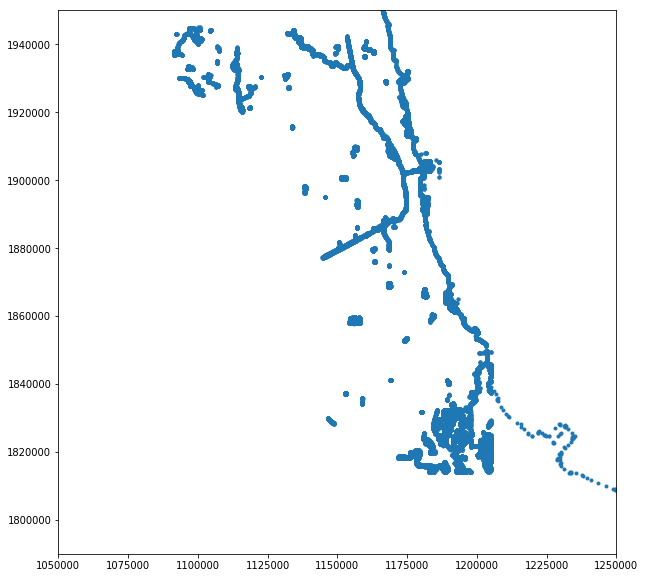

In [21]:
listx = []
listy = []
for sr in sf.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)

plt.figure(figsize=(10,10))        
plt.plot(listx,listy, '.')
plt.xlim((1050000, 1250000))
plt.ylim((1790000, 1950000))
plt.show()


In [26]:
list1 = []
for i in range(100):
    list1.append((sf.records()[i][4],  sf.records()[i][5]))

In [27]:
sf.

[(17756.68055, 664.321573482),
 (977448.39625, 7119.38419393),
 (18024.2925, 692.950275046),
 (954.36875, 132.114867402),
 (7238.91845, 434.296024099),
 (2308.34595, 369.010204292),
 (8398.64405, 452.647366302),
 (19881.53625, 592.166563207),
 (10717.88845, 480.879643381),
 (1956.86905, 373.181760168),
 (10484.5497, 470.741271808),
 (11852.6775, 479.250451733),
 (13876.01, 489.66726867),
 (522311.8678, 7270.96975864),
 (39728.86, 846.202348806),
 (172386.7944, 1913.04064603),
 (10333.62655, 906.133004423),
 (3009.445, 878.867477521),
 (11171.49655, 926.535656681),
 (2496.35625, 886.31089378),
 (542232.68925, 8509.21510935),
 (10457.57185, 1238.22890412),
 (11475.66625, 924.131911407),
 (3204.89875, 868.106610904),
 (8853.98685, 873.429701981),
 (487087.5591, 4945.67795282),
 (135635.235, 2577.32333104),
 (17025.19875, 732.934589476),
 (588103.78305, 5718.87505163),
 (1986.31125, 271.223031802),
 (1998.0897, 212.740354861),
 (16023.9756, 990.36446303),
 (163253.0231, 1978.78611002),
 (2